# In the name of God

-  Mohammad Amin Ansari   _400100757_
- Final Project of course "ML"
- Dr. Shamsollahi



In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **`*libraries:*`**

In [48]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.stats import ttest_ind
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from scipy import stats




# 2.1 Data examination

In [49]:
# Read the CSV file
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Project/train_data.csv")

# Display the first few rows
print(df.head())


   Id  Age MF      LoE  YoW  YoCW   Income Housing    Car     Res
0   0   60  F     Bach    4     4  4759451       R  False  Accept
1   1   60  F     Bach    4     4  4759451       R  False  Accept
2   2   76  M     Bach    8     8  8237019       R   True  Accept
3   3   28  M  Ad. Dip    4     4  9114804       R  False  Accept
4   4   44  M  Ad. Dip   16     5   998868       R  False  Reject


## Removing outlier data:

In [50]:
# Assuming your DataFrame is named 'df'
z_scores = np.abs(stats.zscore(df[['Age', 'Income']]))
threshold = 3
outlier_indices = np.where(z_scores > threshold)

# Keep rows without outliers
df = df.drop(index=outlier_indices[0])


# 2.2 Data Preprocessing

## remove rows containing NaN and convert string columns to numeric

In [51]:
# Remove rows with any NaN values
df.dropna(inplace=True)

# Convert specific columns to numeric
df['Age'] = pd.to_numeric(df['Age'])
df['MF'] = df['MF'].replace({'F': 0, 'M': 1})
df['LoE'] = df['LoE'].replace({'Dip': 0, 'Ad. Dip': 1, 'Bach': 2, 'Mst': 3, 'Doct': 4, 'P. Doct': 5})
df['YoW'] = pd.to_numeric(df['YoW'])
df['YoCW'] = pd.to_numeric(df['YoCW'])
df['Income'] = pd.to_numeric(df['Income'])
#df['Car'] = df['Car'].replace({'False': 0, 'True': 1})
df['Car'] = df['Car'].astype(int)

df['Housing'] = df['Housing'].replace({'O': 0, 'R': 1, 'N': 2})
df['Res'] = df['Res'].replace({'Reject': 0, 'Accept': 1})

print(df)


        Id  Age  MF  LoE  YoW  YoCW   Income  Housing  Car  Res
0        0   60   0    2    4     4  4759451        1    0    1
1        1   60   0    2    4     4  4759451        1    0    1
2        2   76   1    2    8     8  8237019        1    1    1
3        3   28   1    1    4     4  9114804        1    0    1
4        4   44   1    1   16     5   998868        1    0    0
...    ...  ...  ..  ...  ...   ...      ...      ...  ...  ...
1995  1995   61   1    0    9     4  5316246        1    1    1
1996  1996   50   1    1    3     3  2062048        1    1    0
1997  1997   52   1    3    8     6  5811902        1    0    1
1998  1998   41   1    4   15    14  5866909        1    0    1
1999  1999   66   0    2    3     3  8199311        1    1    1

[1955 rows x 10 columns]


## After we cast all data to numeric data we can perform normaliztion:

In [52]:
# Initialize the scaler
scaler = MinMaxScaler()

# Normalize numeric columns (excluding 'Res')
df[['Age', 'LoE', 'YoW', 'YoCW', 'Income', 'Housing']] = scaler.fit_transform(df[['Age', 'LoE', 'YoW', 'YoCW', 'Income', 'Housing']])

print(df)


        Id       Age  MF  LoE   YoW      YoCW    Income  Housing  Car  Res
0        0  0.672414   0  0.4  0.20  0.285714  0.476100      0.5    0    1
1        1  0.672414   0  0.4  0.20  0.285714  0.476100      0.5    0    1
2        2  0.948276   1  0.4  0.40  0.571429  0.824166      0.5    1    1
3        3  0.120690   1  0.2  0.20  0.285714  0.912022      0.5    0    1
4        4  0.396552   1  0.2  0.80  0.357143  0.099707      0.5    0    0
...    ...       ...  ..  ...   ...       ...       ...      ...  ...  ...
1995  1995  0.689655   1  0.0  0.45  0.285714  0.531829      0.5    1    1
1996  1996  0.500000   1  0.2  0.15  0.214286  0.206120      0.5    1    0
1997  1997  0.534483   1  0.6  0.40  0.428571  0.581439      0.5    0    1
1998  1998  0.344828   1  0.8  0.75  1.000000  0.586944      0.5    0    1
1999  1999  0.775862   0  0.4  0.15  0.214286  0.820392      0.5    1    1

[1955 rows x 10 columns]


## Our data preprocessing is done!

# 2.3 Showing the data

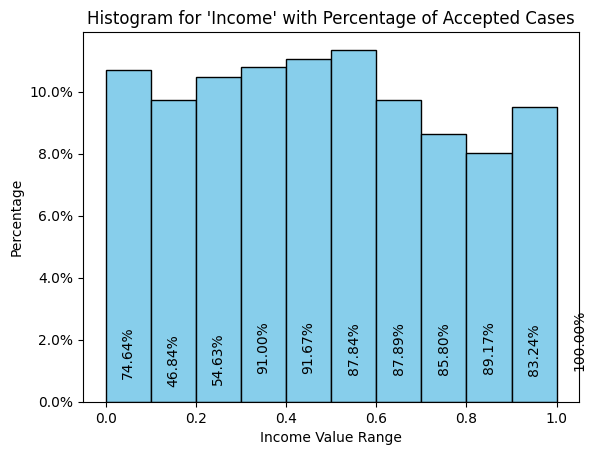

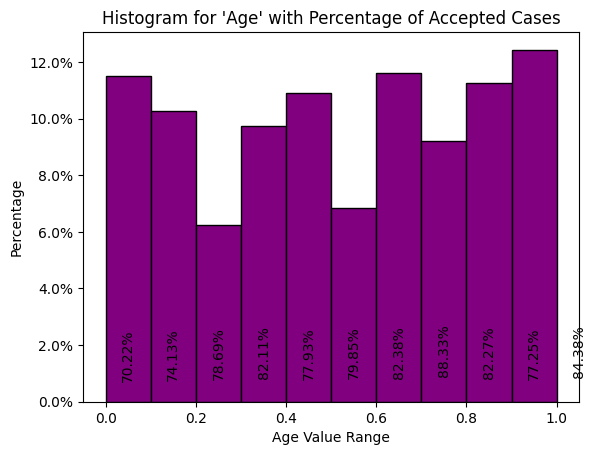

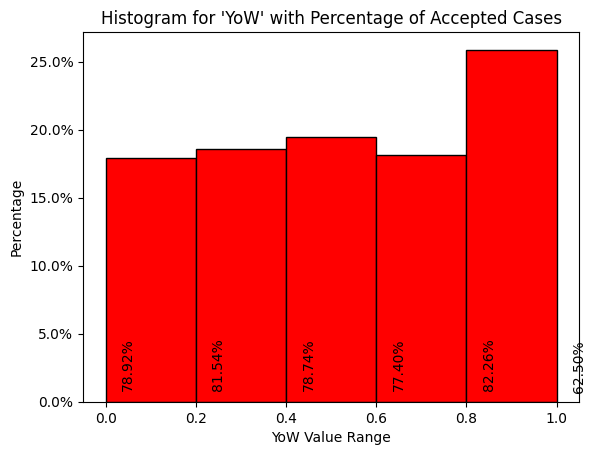

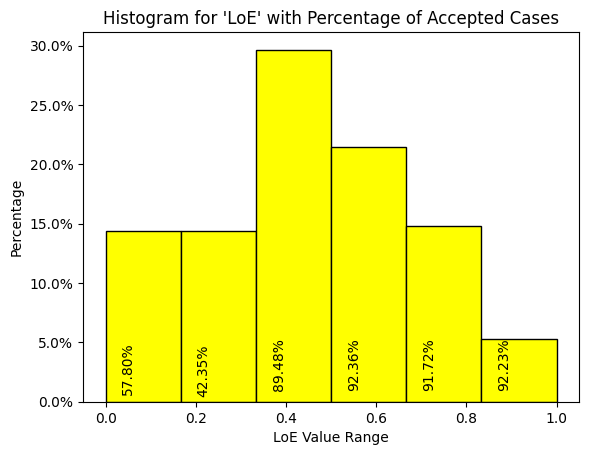

In [53]:
# Calculate histogram and weights
hist, bins = np.histogram(df['Income'], bins=10)
weights = hist / len(df)

# Find the indices of each bin
indices = np.digitize(df['Income'], bins)

# Sum up the 'Res' column values for each bin
accepted_counts = df.groupby(indices)['Res'].sum()

# Calculate the total count of members in each bin
total_counts = df.groupby(indices)['Res'].count()

# Calculate the percentage of acceptance in each bin
acceptance_percentage = accepted_counts / total_counts


# Create the histogram plot with annotations
plt.bar(bins[:-1], weights, width=np.diff(bins), align='edge', label='Histogram', color='skyblue', edgecolor='black')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Add acceptance percentage annotations (with black font color)
# Rotate the text (example: 45 degrees)
for i, p in enumerate(acceptance_percentage):
    plt.text(bins[i] + 0.05 , p/100, f"{p:.2%}", rotation=90, ha='center', va='bottom', color='black')

# Add labels and title
plt.xlabel("Income Value Range")
plt.ylabel("Percentage")
plt.title("Histogram for 'Income' with Percentage of Accepted Cases")


# Show the plot
plt.show()

########################################################################################################################

# Calculate histogram and weights
hist, bins = np.histogram(df['Age'], bins=10)
weights = hist / len(df)

# Find the indices of each bin
indices = np.digitize(df['Age'], bins)

# Sum up the 'Res' column values for each bin
accepted_counts = df.groupby(indices)['Res'].sum()

# Calculate the total count of members in each bin
total_counts = df.groupby(indices)['Res'].count()

# Calculate the percentage of acceptance in each bin
acceptance_percentage = accepted_counts / total_counts


# Create the histogram plot with annotations
plt.bar(bins[:-1], weights, width=np.diff(bins), align='edge', label='Histogram', color='purple', edgecolor='black')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Add acceptance percentage annotations (with black font color)
# Rotate the text (example: 45 degrees)
for i, p in enumerate(acceptance_percentage):
    plt.text(bins[i] + 0.05 , p/100, f"{p:.2%}", rotation=90, ha='center', va='bottom', color='black')

# Add labels and title
plt.xlabel("Age Value Range")
plt.ylabel("Percentage")
plt.title("Histogram for 'Age' with Percentage of Accepted Cases")


# Show the plot
plt.show()

########################################################################################################################

# Calculate histogram and weights
hist, bins = np.histogram(df['YoW'], bins=5)
weights = hist / len(df)

# Find the indices of each bin
indices = np.digitize(df['YoW'], bins)

# Sum up the 'Res' column values for each bin
accepted_counts = df.groupby(indices)['Res'].sum()

# Calculate the total count of members in each bin
total_counts = df.groupby(indices)['Res'].count()

# Calculate the percentage of acceptance in each bin
acceptance_percentage = accepted_counts / total_counts


# Create the histogram plot with annotations
plt.bar(bins[:-1], weights, width=np.diff(bins), align='edge', label='Histogram', color='red', edgecolor='black')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Add acceptance percentage annotations (with black font color)
# Rotate the text (example: 45 degrees)
for i, p in enumerate(acceptance_percentage):
    plt.text(bins[i] + 0.05 , p/100, f"{p:.2%}", rotation=90, ha='center', va='bottom', color='black')

# Add labels and title
plt.xlabel("YoW Value Range")
plt.ylabel("Percentage")
plt.title("Histogram for 'YoW' with Percentage of Accepted Cases")


# Show the plot
plt.show()

########################################################################################################################

# Calculate histogram and weights
hist, bins = np.histogram(df['LoE'], bins=6)
weights = hist / len(df)

# Find the indices of each bin
indices = np.digitize(df['LoE'], bins)

# Sum up the 'Res' column values for each bin
accepted_counts = df.groupby(indices)['Res'].sum()

# Calculate the total count of members in each bin
total_counts = df.groupby(indices)['Res'].count()

# Calculate the percentage of acceptance in each bin
acceptance_percentage = accepted_counts / total_counts


# Create the histogram plot with annotations
plt.bar(bins[:-1], weights, width=np.diff(bins), align='edge', label='Histogram', color='yellow', edgecolor='black')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))

# Add acceptance percentage annotations (with black font color)
# Rotate the text (example: 45 degrees)
for i, p in enumerate(acceptance_percentage):
    plt.text(bins[i] + 0.05 , p/100, f"{p:.2%}", rotation=90, ha='center', va='bottom', color='black')

# Add labels and title
plt.xlabel("LoE Value Range")
plt.ylabel("Percentage")
plt.title("Histogram for 'LoE' with Percentage of Accepted Cases")


# Show the plot
plt.show()


## Showing 2D scatter plot for two random features:

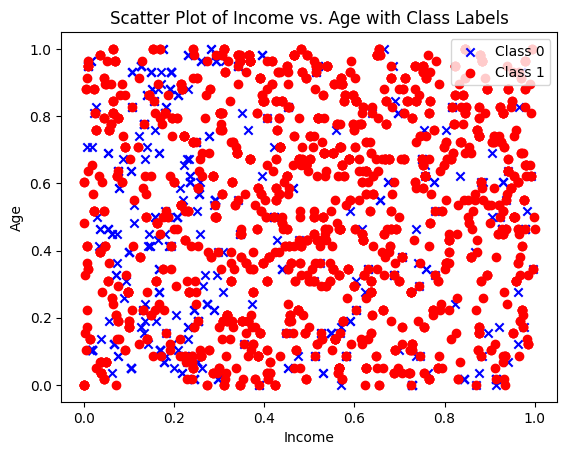

Pearson's correlation coefficient between 'Age' and 'Income': 0.0279


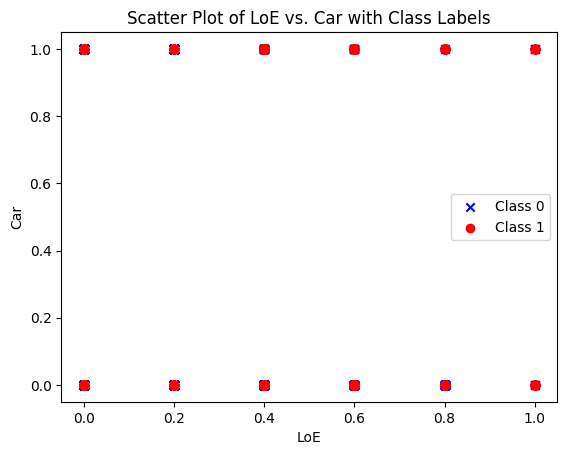

Pearson's correlation coefficient between 'LoE' and 'Car': -0.0619


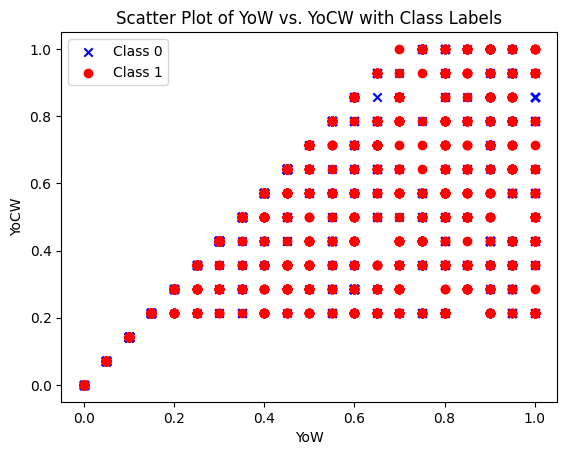

Pearson's correlation coefficient between 'YoW' and 'YoCW': 0.6378


In [54]:
class_0_indices = df[df['Res'] == 0]
class_1_indices = df[df['Res'] == 1]

# Create the scatter plot
plt.scatter(class_0_indices['Income'], class_0_indices['Age'], c='blue', marker='x', label='Class 0')
plt.scatter(class_1_indices['Income'], class_1_indices['Age'], c='red', marker='o', label='Class 1')

# Add labels and title
plt.xlabel("Income")
plt.ylabel("Age")
plt.title("Scatter Plot of Income vs. Age with Class Labels")
plt.legend()

# Show the plot
plt.show()
# Assuming your DataFrame is named 'df'
correlation_coefficient = df['Age'].corr(df['Income'])

print(f"Pearson's correlation coefficient between 'Age' and 'Income': {correlation_coefficient:.4f}")

########################################################################################################################

class_0_indices = df[df['Res'] == 0]
class_1_indices = df[df['Res'] == 1]

# Create the scatter plot
plt.scatter(class_0_indices['LoE'], class_0_indices['Car'], c='blue', marker='x', label='Class 0')
plt.scatter(class_1_indices['LoE'], class_1_indices['Car'], c='red', marker='o', label='Class 1')

# Add labels and title
plt.xlabel("LoE")
plt.ylabel("Car")
plt.title("Scatter Plot of LoE vs. Car with Class Labels")
plt.legend()

# Show the plot
plt.show()
# Assuming your DataFrame is named 'df'
correlation_coefficient = df['LoE'].corr(df['Car'])

print(f"Pearson's correlation coefficient between 'LoE' and 'Car': {correlation_coefficient:.4f}")


########################################################################################################################

class_0_indices = df[df['Res'] == 0]
class_1_indices = df[df['Res'] == 1]

# Create the scatter plot
plt.scatter(class_0_indices['YoW'], class_0_indices['YoCW'], c='blue', marker='x', label='Class 0')
plt.scatter(class_1_indices['YoW'], class_1_indices['YoCW'], c='red', marker='o', label='Class 1')

# Add labels and title
plt.xlabel("YoW")
plt.ylabel("YoCW")
plt.title("Scatter Plot of YoW vs. YoCW with Class Labels")
plt.legend()

# Show the plot
plt.show()
# Assuming your DataFrame is named 'df'
correlation_coefficient = df['YoW'].corr(df['YoCW'])

print(f"Pearson's correlation coefficient between 'YoW' and 'YoCW': {correlation_coefficient:.4f}")


# 2.4 t-test

1) People with higher level of education are more likely to be accepted.

In [55]:
# Create separate groups based on education level
group_high = df[df['LoE'].isin([0.8, 1])]
group_low = df[df['LoE'].isin([0, 0.2, 0.4, 0.6])]

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(group_high['Res'], group_low['Res'])

print(f"T-test results:")
print(f"  T-statistic: {t_statistic:.4f}")
print(f"  P-value: {p_value:.4f}")

if p_value < 0.05:
    print("  Conclusion: Reject the null hypothesis (significant difference)")
else:
    print("  Conclusion: Fail to reject the null hypothesis (no significant difference)")


T-test results:
  T-statistic: 8.8929
  P-value: 0.0000
  Conclusion: Reject the null hypothesis (significant difference)


2) People with higher income have house or car:

In [56]:
# Create separate groups based on income
group_high = df[df['Income'] > 0.9]
group_low = df[df['Income'] < 0.9]

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(group_high['Car'], group_low['Car'])

print(f"T-test results:")
print(f"  T-statistic: {t_statistic:.4f}")
print(f"  P-value: {p_value:.4f}")

if p_value < 0.05:
    print("  Conclusion: Reject the null hypothesis (significant difference)")
else:
    print("  Conclusion: Fail to reject the null hypothesis (no significant difference)")


T-test results:
  T-statistic: 1.1777
  P-value: 0.2391
  Conclusion: Fail to reject the null hypothesis (no significant difference)


3) Men older than 50 have less chance to get accepted in comparison to Men younger than 30.

In [57]:

# Create separate groups for men older than 50 and men younger than 30
group_high = df[(df['MF'] == 1) & (df['Age'] > 0.5)]
group_low = df[(df['MF'] == 1) & (df['Age'] < 0.155)]

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(group_high['Res'], group_low['Res'])

print(f"T-test results:")
print(f"  T-statistic: {t_statistic:.4f}")
print(f"  P-value: {p_value:.4f}")

if p_value < 0.05:
    print("  Conclusion: Reject the null hypothesis (significant difference)")
else:
    print("  Conclusion: Fail to reject the null hypothesis (no significant difference)")


T-test results:
  T-statistic: 4.4146
  P-value: 0.0000
  Conclusion: Reject the null hypothesis (significant difference)


4) Men have more income than women:

In [58]:
men_income = df[df['MF'] == 1]['Income']
women_income = df[df['MF'] == 0]['Income']

# Perform independent two-sample t-test
t_statistic, p_value = ttest_ind(men_income, women_income)

print(f"T-test results:")
print(f"  T-statistic: {t_statistic:.4f}")
print(f"  P-value: {p_value:.4f}")

if p_value < 0.05:
    print("  Conclusion: Reject the null hypothesis (significant difference)")
else:
    print("  Conclusion: Fail to reject the null hypothesis (no significant difference)")

T-test results:
  T-statistic: 0.9610
  P-value: 0.3367
  Conclusion: Fail to reject the null hypothesis (no significant difference)


# * (3) Train and test the model

3.0 Divide data to test and train 5 times:

In [59]:
# Specify the test size (e.g., 20% for testing)
test_size = 0.2

# Separate features (X) and labels (y)
X = df.drop(columns=['Res'])  # Assuming 'Res' is the label column
y = df['Res']

# Initialize empty lists to store train-test splits
X_train_splits = []
X_test_splits = []
y_train_splits = []
y_test_splits = []

# Perform the splits five times with different random states
for _ in range(5):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=_)
    X_train_splits.append(X_train)
    X_test_splits.append(X_test)
    y_train_splits.append(y_train)
    y_test_splits.append(y_test)


#  3.1 Training different models:

##**linear regression:**

In [60]:


# Define hyperparameters to test
solvers = ['liblinear', 'saga']  # Use 'liblinear' or 'saga' for L1 penalty
penalties = ['l1', 'l2']
C_values = [0.01, 0.1, 1.0, 10.0]

best_score = float('-inf')
best_params = {}

# Iterate over hyperparameters
for solver in solvers:
    for penalty in penalties:
        for C in C_values:
            model = LogisticRegression(solver=solver, penalty=penalty, C=C, max_iter=1000)
            scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
            avg_score = scores.mean()

            if avg_score > best_score:
                best_score = avg_score
                best_params = {'solver': solver, 'penalty': penalty, 'C': C}

print("Best Hyperparameters:")
print(best_params)
print(f"Average Accuracy: {best_score:.4f}")


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best Hyperparameters:
{'solver': 'liblinear', 'penalty': 'l1', 'C': 10.0}
Average Accuracy: 0.8455


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


We found that for linear regression best hyperparameters are :

* *{'solver': 'liblinear', 'penalty': 'l1', 'C': 1.0}*

with average accuracy of : 84.81%

training our 5 splits using these hyperparameters:

In [61]:


# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auprc_scores = []

# Iterate over each train-test split
for i in range(5):
    # Fit a logistic regression model with the best hyperparameters
    model = LogisticRegression(solver='liblinear', penalty='l1', C=1.0, max_iter=1000)
    model.fit(X_train_splits[i], y_train_splits[i])

    # Make predictions on the test set
    y_pred = model.predict(X_test_splits[i])

    # Calculate evaluation metrics
    accuracy_scores.append(accuracy_score(y_test_splits[i], y_pred))
    precision_scores.append(precision_score(y_test_splits[i], y_pred))
    recall_scores.append(recall_score(y_test_splits[i], y_pred))
    f1_scores.append(f1_score(y_test_splits[i], y_pred))
    auprc_scores.append(average_precision_score(y_test_splits[i], model.decision_function(X_test_splits[i])))

# Calculate average scores
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_auprc = np.mean(auprc_scores)

# Print the results
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")
print(f"Average AUPRC: {avg_auprc:.4f}")


Average Accuracy: 0.8297
Average Precision: 0.8369
Average Recall: 0.9706
Average F1-score: 0.8985
Average AUPRC: 0.9076


## **SVM**

In [ ]:

# Define hyperparameters to search
param_grid = {
    'C': [0.1, 1, 10],  # Regularization parameter
    'kernel': ['linear', 'rbf'],  # Kernel type
    'gamma': [0.1, 1, 10]  # Kernel coefficient
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=SVC(), param_grid=param_grid, cv=5)

# Fit the model with the grid of hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)




Applying these best parameters on our own splits:

In [ ]:


# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auprc_scores = []

# Iterate over each train-test split
for i in range(5):
    # Fit an SVM model with the specified hyperparameters
    model = SVC(C=10, gamma=0.1, kernel='linear')
    model.fit(X_train_splits[i], y_train_splits[i])

    # Make predictions on the test set
    y_pred = model.predict(X_test_splits[i])

    # Calculate evaluation metrics
    accuracy_scores.append(accuracy_score(y_test_splits[i], y_pred))
    precision_scores.append(precision_score(y_test_splits[i], y_pred))
    recall_scores.append(recall_score(y_test_splits[i], y_pred))
    f1_scores.append(f1_score(y_test_splits[i], y_pred))
    auprc_scores.append(average_precision_score(y_test_splits[i], model.decision_function(X_test_splits[i])))

# Calculate average scores
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_auprc = np.mean(auprc_scores)

# Print the results
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")
print(f"Average AUPRC: {avg_auprc:.4f}")


Average Accuracy: 0.7903
Average Precision: 0.8088
Average Recall: 0.9567
Average F1-score: 0.8764
Average AUPRC: 0.8979


## **Decision Tree**

In [ ]:


# Define hyperparameters to search
param_grid = {
    'max_depth': np.arange(2, 11),  # Example: Vary max depth from 2 to 10
    'min_samples_split': [2, 5, 10],  # Example: Test different min samples split
    'min_samples_leaf': [1, 2, 4]  # Example: Vary min samples leaf
}

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5)

# Fit the model with the grid of hyperparameters
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)

# Evaluate the model on the test set using the best hyperparameters
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)


Best Hyperparameters:
{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 5}


Applying Best Hyperparameters:

* {'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 5}

on our splits:


In [ ]:

# Initialize lists to store evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
auprc_scores = []

# Iterate over each train-test split
for i in range(5):
    # Fit a decision tree model with the specified hyperparameters
    model = DecisionTreeClassifier(max_depth=9, min_samples_leaf=2, min_samples_split=5)
    model.fit(X_train_splits[i], y_train_splits[i])

    # Make predictions on the test set
    y_pred = model.predict(X_test_splits[i])

    # Calculate evaluation metrics
    accuracy_scores.append(accuracy_score(y_test_splits[i], y_pred))
    precision_scores.append(precision_score(y_test_splits[i], y_pred))
    recall_scores.append(recall_score(y_test_splits[i], y_pred))
    f1_scores.append(f1_score(y_test_splits[i], y_pred))
    auprc_scores.append(average_precision_score(y_test_splits[i], model.predict_proba(X_test_splits[i])[:, 1]))

# Calculate average scores
avg_accuracy = np.mean(accuracy_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_f1 = np.mean(f1_scores)
avg_auprc = np.mean(auprc_scores)

# Print the results
print(f"Average Accuracy: {avg_accuracy:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1-score: {avg_f1:.4f}")
print(f"Average AUPRC: {avg_auprc:.4f}")


Average Accuracy: 0.8522
Average Precision: 0.8930
Average Recall: 0.9204
Average F1-score: 0.9063
Average AUPRC: 0.9021


In [ ]:

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[ 53  27]
 [ 28 283]]


confusion matrix for last model:
[[ 53  27]
 [ 28 283]]

 because members of 2 class are not equal (accepted class has much more members) accuracy by itself couldnt be the best score to measure.

# Building my final model : voting method

In [ ]:

model_LR = LogisticRegression(solver='liblinear', penalty='l1', C=1.0, max_iter=1000)
model_LR.fit(X, y)
model_SVM = SVC(C=10, gamma=0.1, kernel='linear')
model_SVM.fit(X, y)
model_DT = DecisionTreeClassifier(max_depth=9, min_samples_leaf=2, min_samples_split=5)
model_DT.fit(X, y)


# Create a list of tuples (model_name, model_instance)
models = [('model_LR', model_LR), ('model_SVM', model_SVM), ('model_DT', model_DT)]  # Add your models

# Create a voting classifier (hard voting by default)
voting_classifier = VotingClassifier(estimators=models)

# Fit the voting classifier on your data (X_train, y_train)
voting_classifier.fit(X, y)


VotingClassifier(estimators=[('model_LR',
                              LogisticRegression(max_iter=1000, penalty='l1',
                                                 solver='liblinear')),
                             ('model_SVM',
                              SVC(C=10, gamma=0.1, kernel='linear')),
                             ('model_DT',
                              DecisionTreeClassifier(max_depth=9,
                                                     min_samples_leaf=2,
                                                     min_samples_split=5))])

In [ ]:
# Assuming you have already trained the voting_classifier and have a DataFrame called 'df_test'
# Make predictions on the test data
y_pred = voting_classifier.predict(X)

# Calculate evaluation metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
from sklearn.metrics import average_precision_score
synthetic_probs = [0.5 if pred == 1 else 0 for pred in y_pred]

# Calculate AUPRC using the synthetic probabilities
auprc_hard_voting = average_precision_score(y, synthetic_probs)



# Print the scores
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUPRC (Hard Voting): {auprc_hard_voting:.4f}")


Accuracy: 0.8696
Precision: 0.8693
Recall: 0.9832
F1-score: 0.9228
AUPRC (Hard Voting): 0.8680


# 3.3 Predicting test_data_1.csv file using our best model:

In [ ]:

model_LR = LogisticRegression(solver='liblinear', penalty='l1', C=1.0, max_iter=1000)
model_LR.fit(X, y)


# Read the test data from a CSV file (replace 'test_data.csv' with your actual file name)
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Project/test_data_1.csv')

z_scores = np.abs(stats.zscore(test_data[['Age', 'Income']]))
threshold = 3
outlier_indices = np.where(z_scores > threshold)

# Keep rows without outliers
test_data = test_data.drop(index=outlier_indices[0])

# Remove rows with any NaN values
test_data.dropna(inplace=True)

# Convert specific columns to numeric
test_data['Age'] = pd.to_numeric(test_data['Age'])
test_data['MF'] = test_data['MF'].replace({'F': 0, 'M': 1})
test_data['LoE'] = test_data['LoE'].replace({'Dip': 0, 'Ad. Dip': 1, 'Bach': 2, 'Mst': 3, 'Doct': 4, 'P. Doct': 5})
test_data['YoW'] = pd.to_numeric(test_data['YoW'])
test_data['YoCW'] = pd.to_numeric(test_data['YoCW'])
test_data['Income'] = pd.to_numeric(test_data['Income'])
test_data['Car'] = test_data['Car'].astype(int)

test_data['Housing'] = test_data['Housing'].replace({'O': 0, 'R': 1, 'N': 2})

# Initialize the scaler
scaler = MinMaxScaler()

# Normalize numeric columns (excluding 'Res')
test_data[['Age', 'LoE', 'YoW', 'YoCW', 'Income', 'Housing']] = scaler.fit_transform(test_data[['Age', 'LoE', 'YoW', 'YoCW', 'Income', 'Housing']])


# Make predictions on the test data
predicted_labels = model_LR.predict(test_data)

# Create a DataFrame with the predicted labels
predicted_df = pd.DataFrame({'Predicted_Labels': predicted_labels})

# Save the predicted labels to a CSV file
predicted_df.to_csv('/content/drive/MyDrive/Colab Notebooks/Project/predicted_labels_test_data_1.csv', index=False)



# 4 Simplifying Model

In [ ]:

# Fit the logistic regression model
model_LR.fit(X, y)

# Calculate feature correlations with the predicted label
feature_correlations = X.corrwith(pd.Series(model_LR.predict(X)))

# Sort features by absolute correlation (higher is better)
sorted_features = feature_correlations.abs().sort_values(ascending=False)

# Remove the least important feature (e.g., the last one)
least_important_feature = sorted_features.index[-1]
X_reduced_1 = X.drop(columns=[least_important_feature])

print(f"Removed feature: {least_important_feature}")


model_LR_reduced_1 = LogisticRegression(solver='liblinear', penalty='l1', C=1.0, max_iter=1000)
model_LR_reduced_1.fit(X_reduced_1, y)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score
y_pred = model_LR_reduced_1.predict(X_reduced_1)

# Calculate evaluation metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auprc = average_precision_score(y, model_LR_reduced_1.decision_function(X_reduced_1))

# Print the scores
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUPRC: {auprc:.4f}")


Removed feature: MF
Accuracy: 0.8512
Precision: 0.8554
Recall: 0.9774
F1-score: 0.9123
AUPRC: 0.9161


second stage reducing:

In [ ]:

# Calculate feature correlations with the predicted label
feature_correlations = X_reduced_1.corrwith(pd.Series(model_LR_reduced_1.predict(X_reduced_1)))

# Sort features by absolute correlation (higher is better)
sorted_features = feature_correlations.abs().sort_values(ascending=False)

# Remove the least important feature (e.g., the last one)
least_important_feature = sorted_features.index[-1]
X_reduced_2 = X_reduced_1.drop(columns=[least_important_feature])

print(f"Removed feature: {least_important_feature}")


model_LR_reduced_2 = LogisticRegression(solver='liblinear', penalty='l1', C=1.0, max_iter=1000)
model_LR_reduced_2.fit(X_reduced_2, y)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score
y_pred = model_LR_reduced_2.predict(X_reduced_2)

# Calculate evaluation metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auprc = average_precision_score(y, model_LR_reduced_2.decision_function(X_reduced_2))

# Print the scores
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUPRC: {auprc:.4f}")


Removed feature: Income
Accuracy: 0.7872
Precision: 0.8094
Recall: 0.9567
F1-score: 0.8769
AUPRC: 0.9112


doing this third time:

In [ ]:

# Calculate feature correlations with the predicted label
feature_correlations = X_reduced_2.corrwith(pd.Series(model_LR_reduced_2.predict(X_reduced_2)))

# Sort features by absolute correlation (higher is better)
sorted_features = feature_correlations.abs().sort_values(ascending=False)

# Remove the least important feature (e.g., the last one)
least_important_feature = sorted_features.index[-1]
X_reduced_3 = X_reduced_2.drop(columns=[least_important_feature])

print(f"Removed feature: {least_important_feature}")


model_LR_reduced_3 = LogisticRegression(solver='liblinear', penalty='l1', C=1.0, max_iter=1000)
model_LR_reduced_3.fit(X_reduced_3, y)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score
y_pred = model_LR_reduced_3.predict(X_reduced_3)

# Calculate evaluation metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auprc = average_precision_score(y, model_LR_reduced_3.decision_function(X_reduced_3))

# Print the scores
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUPRC: {auprc:.4f}")

Removed feature: LoE
Accuracy: 0.7923
Precision: 0.7923
Recall: 1.0000
F1-score: 0.8841
AUPRC: 0.8242


# 5 Competition

In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from scipy.stats import ttest_ind
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

# Read the CSV file
df = pd.read_csv("train_data.csv")
z_scores = np.abs(stats.zscore(df[['Age', 'Income']]))
threshold = 3
outlier_indices = np.where(z_scores > threshold)
df = df.drop(index=outlier_indices[0])
df.dropna(inplace=True)
df['Age'] = pd.to_numeric(df['Age'])
df['MF'] = df['MF'].replace({'F': 0, 'M': 1})
df['LoE'] = df['LoE'].replace({'Dip': 0, 'Ad. Dip': 1, 'Bach': 2, 'Mst': 3, 'Doct': 4, 'P. Doct': 5})
df['YoW'] = pd.to_numeric(df['YoW'])
df['YoCW'] = pd.to_numeric(df['YoCW'])
df['Income'] = pd.to_numeric(df['Income'])
df['Car'] = df['Car'].astype(int)
df['Housing'] = df['Housing'].replace({'O': 0, 'R': 1, 'N': 2})
df['Res'] = df['Res'].replace({'Reject': 0, 'Accept': 1})
scaler = MinMaxScaler()
df[['Age', 'LoE', 'YoW', 'YoCW', 'Income', 'Housing']] = scaler.fit_transform(df[['Age', 'LoE', 'YoW', 'YoCW', 'Income', 'Housing']])


# Separate features (X) and labels (y)
X = df.drop(columns=['Res'])
y = df['Res']

model_LR = LogisticRegression(solver='liblinear', penalty='l1', C=1.0, max_iter=1000)
model_LR.fit(X, y)



# Read the test data from a CSV file
test_data = pd.read_csv('test_data_2.csv')
z_scores = np.abs(stats.zscore(test_data[['Age', 'Income']]))
threshold = 3
outlier_indices = np.where(z_scores > threshold)
test_data = test_data.drop(index=outlier_indices[0])
test_data.dropna(inplace=True)
test_data['Age'] = pd.to_numeric(test_data['Age'])
test_data['MF'] = test_data['MF'].replace({'F': 0, 'M': 1})
test_data['LoE'] = test_data['LoE'].replace({'Dip': 0, 'Ad. Dip': 1, 'Bach': 2, 'Mst': 3, 'Doct': 4, 'P. Doct': 5})
test_data['YoW'] = pd.to_numeric(test_data['YoW'])
test_data['YoCW'] = pd.to_numeric(test_data['YoCW'])
test_data['Income'] = pd.to_numeric(test_data['Income'])
test_data['Car'] = test_data['Car'].astype(int)
test_data['Housing'] = test_data['Housing'].replace({'O': 0, 'R': 1, 'N': 2})
scaler = MinMaxScaler()
test_data[['Age', 'LoE', 'YoW', 'YoCW', 'Income', 'Housing']] = scaler.fit_transform(test_data[['Age', 'LoE', 'YoW', 'YoCW', 'Income', 'Housing']])

# Make predictions on the test set
y_pred = model.predict(test_data)


# Calculate evaluation metrics
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred)
recall = recall_score(y, y_pred)
f1 = f1_score(y, y_pred)
auprc = average_precision_score(y, model_LR_reduced_1.decision_function(X_reduced_1))

# Print the scores
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"AUPRC: {auprc:.4f}")
